In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *
from EnKF import *

np.random.seed(0)
noise_percent = 100

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n = 40
F = 16.

def shift(x, s):
    if s == 0: return x
    else: return np.concatenate([x[s:], x[:s]])
    
def L96(x,t,params):
    F = params
    return (shift(x,1)-shift(x,-2))*shift(x,-1)-x+F

(0, 1000)

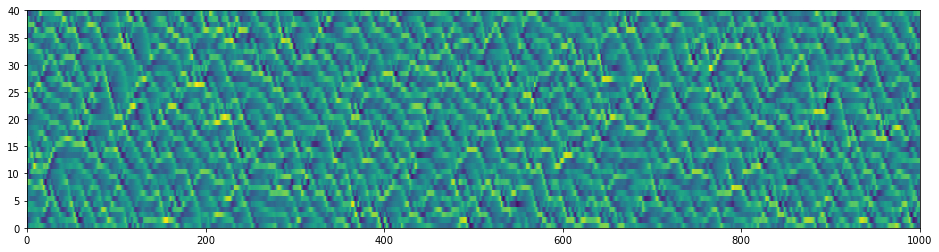

In [3]:
x0 = np.exp(-(np.arange(n)-n/2)**2 / 16)

t = np.arange(0.0, 60.0, 0.05); dt = t[1]-t[0]
X = odeint(L96, x0, t, (F,))[200:,:].T # remove initial transient
t = t[200:]
m = X.shape[1]

figure(figsize = (16,4))
pcolor(X)
xlim(0,m)

In [4]:
def tf_shift(x, s):
    
    n,m = tf.shape(x).eval()
        
    if s == 0: return x
    elif s>0: return tf.concat([tf.slice(x,[s,0],[n-s,m]),tf.slice(x,[0,0],[s,m])], axis = 0)
    else: return tf.concat([tf.slice(x,[n+s,0],[-s,m]),tf.slice(x,[0,0],[n+s,m])], axis = 0)
        
def tf_L96(x, F = F):
    
    n,m = tf.shape(x).eval()
    return (tf_shift(x,1)-tf_shift(x,-2))*tf_shift(x,-1)-x+F

def RK4(x, f, params, h):
    
    b = [1/6,1/3,1/3,1/6]
    A = [[],[1/2],[0, 1/2],[0,0,1]]

    k1 = np.array(f(x, 0, params))
    k2 = np.array(f(x + h*A[1][0]*k1, 0, params))
    k3 = np.array(f(x + h*A[2][0]*k1 + h*A[2][1]*k2, 0, params))
    k4 = np.array(f(x + h*A[3][0]*k1 + h*A[3][1]*k2 + h*A[3][2]*k3, 0, params))
    
    return x+h*(b[0]*k1+b[1]*k2+b[2]*k3+b[3]*k4)

def L96_step(x, h = dt, params = (F)):

    return RK4(x, L96, params, h)

def Identity(x): return x

In [5]:
noise_level = 0.01*noise_percent*np.var(X)
measurement_noise = np.sqrt(noise_level)*np.random.randn(n,m)
Y = X + measurement_noise

In [6]:
Ef, Ea, Es = EnRTS(Y, L96_step, Identity, Y[:,0], noise_level*np.eye(n), \
                   noise_level*np.eye(n), (dt**4)**2*np.eye(n), 500)

X_EnRTS = Es.mean(1)
Err_EnRTS = abs(X_EnRTS-X)

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

optimizer, X_hat_tf, cost = create_computational_graph(Y, t, tf_L96, method = 'Gauss3')

init = tf.global_variables_initializer()
sess.run(init)

optimizer.minimize(sess)
X_implicit = X_hat_tf.eval()
Err_implicit = abs(X_implicit-X)

sess.close()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.008560
  Number of iterations: 11253
  Number of functions evaluations: 11308


/home/samuel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


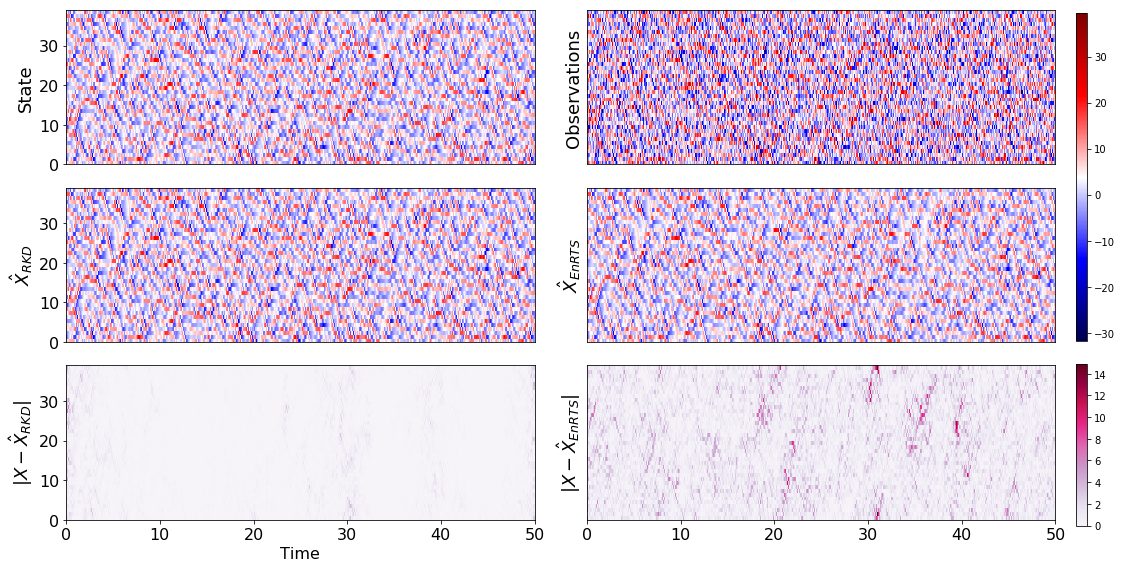

In [8]:
fig = figure(figsize = (15,8))

label_fs = 16
cmap = 'seismic'
# cmap = 'RdBu'
err_cmap = 'RdPu' 
err_cmap = 'PuRd' 

Xticks = [0,10,20,30,40,50]
Yticks = [0,10,20,30]

vmax_sol = np.max([Y, X, X_implicit, X_EnRTS])
vmin_sol = np.min([Y, X, X_implicit, X_EnRTS])
vmax_err = np.max([Err_EnRTS, Err_implicit])

xx,tt = meshgrid(t-10,np.arange(40))

# State
subplot(3,2,1)
obs_plot = pcolor(xx, tt, X, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
ylabel('State', fontsize = label_fs+2)
yticks(Yticks, fontsize = label_fs)

# Observations
subplot(3,2,2)
pcolor(xx, tt, Y, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
yticks([])
xticks([])
ylabel('Observations', fontsize = label_fs+2)

# Implicit denoising state estimate
subplot(3,2,3)
pcolor(xx, tt, X_implicit, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
xticks([])
yticks(Yticks, fontsize = label_fs)
ylabel(r'$\hat{X}_{RKD}$', fontsize = label_fs+2)

# EnRTS Denoising state estimate
subplot(3,2,4)
pcolor(xx, tt, X_EnRTS, cmap = cmap, vmin = vmin_sol, vmax = vmax_sol)
yticks([])
xticks([])
ylabel(r'$\hat{X}_{EnRTS}$', fontsize = label_fs+2)

# Implicit denoising error
subplot(3,2,5)
pcolor(xx, tt, Err_implicit, cmap = err_cmap, vmin = 0, vmax = vmax_err)
yticks(Yticks, fontsize = label_fs)
xticks(Xticks, fontsize = label_fs)
xlabel('Time', fontsize = label_fs)
ylabel(r'$|X - \hat{X}_{RKD}|$', fontsize = label_fs+2)

# EnRTS error
subplot(3,2,6)
err_rts_plot = pcolor(xx, tt, Err_EnRTS, cmap = err_cmap, vmin = 0, vmax = vmax_err)
yticks([])
xticks(Xticks, fontsize = label_fs)
ylabel(r'$|X - \hat{X}_{EnRTS}|$', fontsize = label_fs+2)

position=fig.add_axes([1.,0.08,0.01,0.28])
fig.colorbar(err_rts_plot,cax=position) 

position2=fig.add_axes([1.,0.4,0.01,0.57])
fig.colorbar(obs_plot,cax=position2) 

tight_layout()

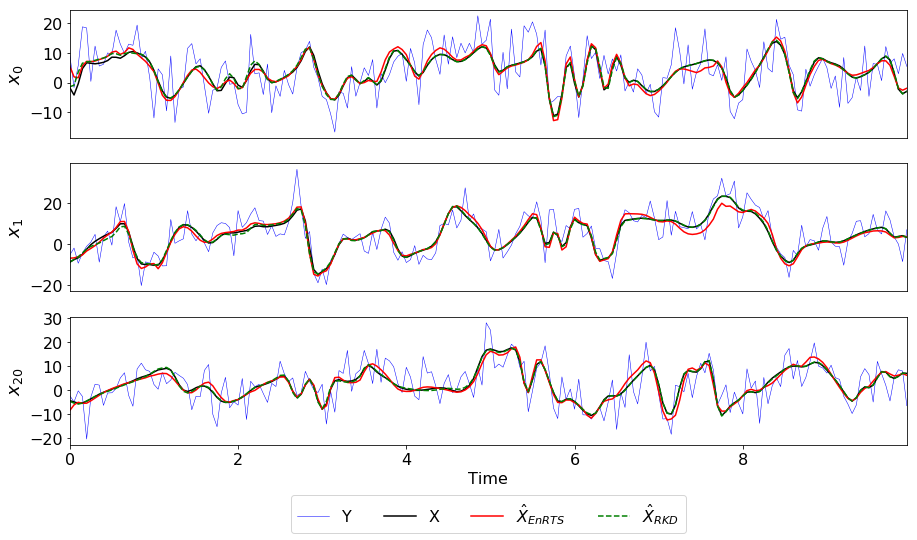

In [9]:
figure(figsize = (15,8))

start = 0
end = 200

X_hat = np.mean(Ef, axis = 1)

subplot(3,1,1); plot(t[start:end]-t[start], Y[0,start:end], 'b', linewidth = 0.5); xlim([0,t[end-1]-t[start]])
subplot(3,1,2); plot(t[start:end]-t[start], Y[1,start:end], 'b', linewidth = 0.5);  xlim([0,t[end-1]-t[start]])
subplot(3,1,3); plot(t[start:end]-t[start], Y[20,start:end], 'b', linewidth = 0.5, label = 'Y')
xlim([0,t[end-1]-t[start]])

subplot(3,1,1); plot(t[start:end]-t[start], X[0,start:end], 'k')
subplot(3,1,2); plot(t[start:end]-t[start], X[1,start:end], 'k')
subplot(3,1,3); plot(t[start:end]-t[start], X[20,start:end], 'k', label = 'X')

subplot(3,1,1); plot(t[start:end]-t[start], X_EnRTS[0,start:end], 'r')
subplot(3,1,2); plot(t[start:end]-t[start], X_EnRTS[1,start:end], 'r')
subplot(3,1,3); plot(t[start:end]-t[start], X_EnRTS[20,start:end], 'r', label = r'$\hat{X}_{EnRTS}$')

subplot(3,1,1); plot(t[start:end]-t[start], X_implicit[0,start:end], 'g--')
subplot(3,1,2); plot(t[start:end]-t[start], X_implicit[1,start:end], 'g--')
subplot(3,1,3); plot(t[start:end]-t[start], X_implicit[20,start:end], 'g--', label = r'$\hat{X}_{RKD}$')

subplot(3,1,1)
yticks(fontsize = 16)
ylabel(r'$x_0$', fontsize = 18)
xticks([])

subplot(3,1,2)
yticks(fontsize = 16)
ylabel(r'$x_1$', fontsize = 18)
xticks([])

subplot(3,1,3)
yticks(fontsize = 16)
ylabel(r'$x_{20}$', fontsize = 18)
xticks(fontsize = 16)
xlabel('Time', fontsize = 16)

legend(fontsize = 16, loc='lower center', bbox_to_anchor=(0.5, -0.75),
          ncol=4)